# Исследование надежности заёмщиков


Кредитному отделу банка нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Данные, которые нам предоставил банк — статистика о платёжеспособности клиентов.


***Описание данных:***
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

## Изучу общую информацию о данных

In [25]:
import pandas as pd

try:
    data = pd.read_csv('/datasets/data.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

Рассмотрю данные и изучу основную информацию.

In [26]:
data[:5]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Предобработка данных

### Удаление пропусков

Посмотрю сколько пропусков в данных.

In [28]:
pd.DataFrame(data.isna().sum().sort_values(ascending=False)).style.background_gradient('coolwarm')

,0
days_employed,2174
total_income,2174
children,0
dob_years,0
education,0
education_id,0
family_status,0
family_status_id,0
gender,0
income_type,0


В двух столбцах есть пропущенные значения. Один из них — `days_employed`. Пропуски в этом столбце я обработаю позже. Другой столбец с пропущенными значениями — `total_income` — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца `income_type`.

In [29]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

В данных встречаются аномалии - отрицательное количество дней трудового стажа в столбце `days_employed`. Обработаем значения в этом столбце, заменив все отрицательные значения положительными с помощью метода `abs()`.

In [30]:
data['days_employed'] = data['days_employed'].abs()

Выведу для каждого типа занятости медианное значение трудового стажа `days_employed` в днях:

In [31]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Исправлять такие значения не буду, потому что эти столбцы не понадобятся мне для исследования.

Посмотрю перечень уникальных значений столбца `children`.

In [32]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

В столбце `children` есть два аномальных значения. Удалю строки, в которых встречаются такие аномальные значения из датафрейма `data`.

In [33]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

### Удаление пропусков

Заполню пропуски в столбце `days_employed` медианными значениями по каждому типу занятости `income_type`.

In [34]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

Посмотрю все ли пропуски обработаны.

In [35]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

Заменю тип данных в столбце `total_income` на целочисленный с помощью метода `astype()`.

In [36]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

In [37]:
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

В столбце `education` есть одни и те же значения, но записанные по-разному. Для обработки неявных дубликатов приведу все значения к нижнему регистру.

In [38]:
data['education'] = data['education'].str.lower()

Посмотрю количество строк-дубликатов в остальных данных. Если такие строки присутствуют, удалю их.

In [39]:
data.duplicated().sum()

71

In [ ]:
data = data.drop_duplicates()

### Категоризация данных

Создам в датафрейме `data` столбец `total_income_category` с категориями по зарплате:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [40]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [41]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Выведу перечень уникальных целей взятия кредита из столбца `purpose`.

In [ ]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создам функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [42]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [43]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

# Исследование данных и ответы на вопросы

### Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

debt,amount_child,0,1,debt_share
0,0,13086,1063,0.075129
1,1,4374,444,0.092154
2,2,1861,194,0.094404
3,3 и более,349,31,0.081579


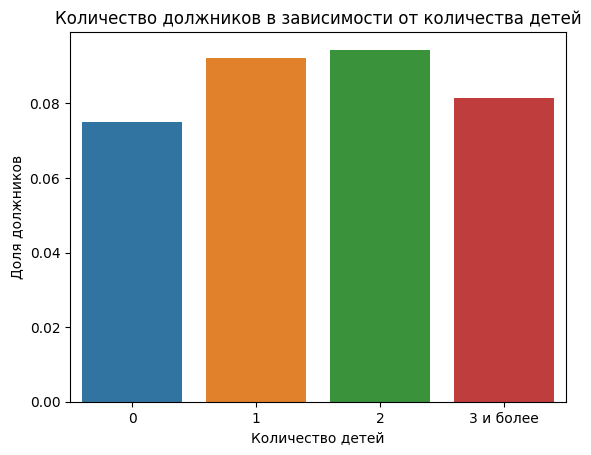

In [60]:
# создам функцию, которая обьединяет в группу людей, имеющих более трех детей
def amount_children(child):
    if child == 0:
        return '0'
    elif child == 1:
        return '1'
    elif child == 2:
        return '2'
    elif child >= 3:
        return '3 и более'

# создам столбец amount_child с новыми категориями количества детей
data['amount_child'] = data['children'].apply(amount_children)

#делаю сводную таблицу, которую группируем по количеству детей по значениям задолженности debt
#функцией count считаю количество людей, платящих в срок (столбец 0) и людей, у кого задолженность была(столбец 1)
debt_child = data.pivot_table(index='amount_child', columns='debt', values='purpose', aggfunc='count') \
                            .reset_index()

#добавляю столбец, в котором рассчитаю долю людей, имеющих задолженность по кредитам
debt_child['debt_share'] = debt_child[1] / (debt_child[0] + debt_child[1])
display(debt_child)
print()

# строю столбчатую диаграмму, где по оси X будет количество детей, а по Y доля должников
ax = sns.barplot(debt_child, x='amount_child', y='debt_share')
ax.set(xlabel='Количество детей', ylabel='Доля должников', 
       title='Количество должников в зависимости от количества детей')
plt.show()

**Вывод:** 
Как и ожидалось, кредит в срок чаще возвращают люди, не имеющие детей (это 92,5%).

А вот среди людей, имеющих детей оказалось, что многодетные даже реже пропускают выплаты в срок (8%), чем другие категории, имеющие детей. Но выборка многодетных в 15 раз меньше, чем выборка с 1 и 2 детьми.

Больше всего риск пропустить выплату по кредиту в срок у людей с одним и двумя детьми. Это примерно по 9% от общего числа заемщиков в соответсвующей категории.

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

debt,family_status,0,1,share_debt
0,Не женат / не замужем,2526,273,0.097535
1,в разводе,1105,84,0.070648
2,вдовец / вдова,889,63,0.066176
3,гражданский брак,3775,385,0.092548
4,женат / замужем,11375,927,0.075354


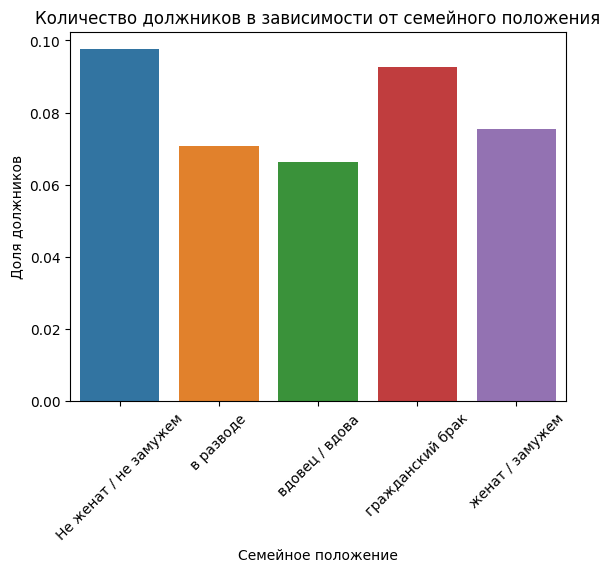

In [66]:
#строю сводную таблицу, сгрупированную по столбцу с семейным положением и значениям о задолженности по выплатам
#к значениям применю функцию count, для подсчета количества людей в каждой категории
debt_family = data.pivot_table(index='family_status', columns='debt', values='purpose', aggfunc='count')\
                              .reset_index()

#добавляю столбец share_debt, в который добавлю рассчет доли должников
debt_family['share_debt'] = debt_family[1] / (debt_family[0] + debt_family[1])
display(debt_family)
print()

#строю столбчатую диаграмму, ось X - семейное положение, Y - доля должников
ax = sns.barplot(debt_family, x = 'family_status', y = 'share_debt')
ax.set(xlabel='Семейное положение', ylabel='Доля должников', 
       title='Количество должников в зависимости от семейного положения')
plt.xticks(rotation=45)
plt.show()

**Вывод:** 
Чаще всего (в 9-10% случаев) пропускают выплату в срок люди, которые никогда не были в официальном браке. Это категории не женат/не замужем и гражданский брак.

Реже пропустят выплаты те, кто женат/замужем (7,5%) и те, кто находится в разводе (7%).

Самые пунктуальные при возврате кредита это вдовец/вдова, из них заплатят в срок 94% людей.

Более своевременная выплата кредитов последних трех категорий может быть связана с государственной поддержкой, как молодых семей, так и одиноких родителей, которая часто заключается в более выгодных условиях кредитования. Также может отражаться более ответственный подход и размеренное устройство жизни, состоящих/состоявших в официальном браке людей.

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

income_category  debt                 
                    sum  count      mean
0            A, B   356   5039  0.070649
1               C  1353  15992  0.084605
2            D, E    23    371  0.061995

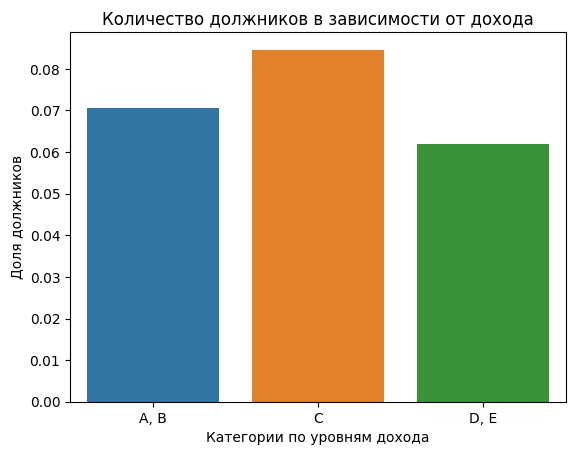

In [72]:
# создаю функцию, которая обьединет в группу людей, имеющих самые высокие и самые низкие доходы
def income(category):
    if category == 'A' or category == 'B':
        return 'A, B'
    elif category == 'D' or category == 'E':
        return 'D, E'
    elif category == 'C':
        return 'C'
# создаю столбец income_category с объединенными категориями уровня дохода
data['income_category'] = data['total_income_category'].apply(income)

#строю таблицу, сгрупированную по столбцу с категориями уровня дохода
#к столбцу с задолженностями применю функции count, sum, mean
debt_income = data.groupby('income_category').agg({'debt': ['sum', 'count', 'mean']}).reset_index()
display(debt_income)
print()

#строим столбчатую диаграмму, используя библиотеку seaborn
#ось X - категории по уровням дохода, Y - доля должников
ax = seaborn.barplot(x=debt_income['income_category'], y=debt_income['debt']['mean'])
ax.set(xlabel='Категории по уровням дохода', ylabel='Доля должников', 
       title='Количество должников в зависимости от дохода')
plt.show()

**Вывод:** 
Люди с самым низким доходом (до 50.000 руб) являются самыми пунктуальными плательщиками, но они и берут кредиты в десятки раз реже.

Те, кто зарабатывают от 50 до 200 тысяч рублей чаще всего пропускают срок погшения кредита (8,5% выплат).

Люди с высокими доходами пропустят выплату в 7% случаев.

### Как разные цели кредита влияют на его возврат в срок?

debt,purpose_category,0,1,share_debt
0,операции с автомобилем,3888,400,0.093284
1,операции с недвижимостью,10000,780,0.072356
2,получение образования,3628,369,0.092319
3,проведение свадьбы,2154,183,0.078306


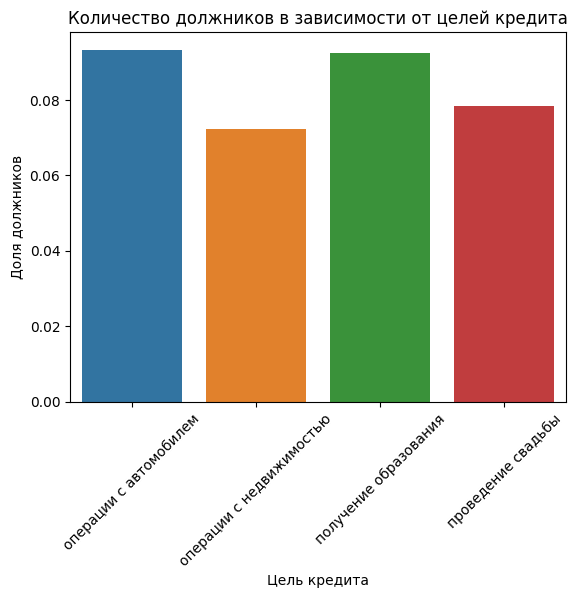

In [74]:
#строим сводную таблицу, сгрупированную по столбцу с целями кредита и значениям о задолженности по выплатам
#к значениям применим функцию count, для подсчета количества людей в каждой категории
debt_purpose = data.pivot_table(index='purpose_category', columns='debt', values='purpose', aggfunc='count')\
                              .reset_index()

#добавляем столбец share_debt, в который добавим рассчет доли должников
debt_purpose['share_debt'] = debt_purpose[1] / (debt_purpose[0] + debt_purpose[1])
display(debt_purpose)
print()

#строим столбчатую диаграмму, ось X - цель кредита, Y - доля должников
ax = seaborn.barplot(debt_purpose, x='purpose_category', y='share_debt')
ax.set(xlabel='Цель кредита', ylabel='Доля должников', 
       title='Количество должников в зависимости от целей кредита')
plt.xticks(rotation=45)
plt.show()

**Вывод:** 
Те, кто берет кредит на покупку недвижимости, будут в 93% платить кредит в срок. Это самый хороший показатель в данном сравнении.

Немного хуже платят люди, которые берут кредит на проведение свадьбы (~8% пропустят выплату).

И самые не исполнительные заемщики это студенты и автомобилисты. Просрочат платеж по кредиту 9% в каждой категории.

### Возможные причины появления пропусков в исходных данных?

Вероятнее всего данные были пропущены по техническим причинам, нежели из-за человеческого фактора. 
1. Навряд ли какой то банк одобрит кредит человеку, не указывающему уровень своего дохода.
2. Пропуски в одинаковом количестве были пропущены в столбце с зарплатой и в столбце со стажем, что указывает на ошибку, которая могла произойти в момент записи/переносе данных.

### Почему заполнить пропуски медианным значением — лучшее решение для количественных переменных?

В количественных переменных могут быть аномальные значения, значения, не отражающие основную картину и являющиеся скорее исключением, чем правилом. Например, из 10 пенсионеров девять будут иметь доход в 50 т.р., а десятый 150 т.р.

Поэтому, чтобы исключить смещение в ту или иную сторону, для заполнения пропусков  лучше использовать медианное значение вместо среднего арифметического.

### Общий вывод

<div style="border:solid blue 2px; padding: 30px">

В результате проведенного анализа выяснилось, что количество детей, уровень дохода, цель кредита и даже семейное положения влияет на возврат кредита в срок.
    
   Люди, не имеющие детей, пропустят срок платежа по кредиту в 7,5% случаев, в то время, как 9% людей с 1 или 2 детьми и 8% многодетных не заплатят в срок. Выборка многодетных семей гораздо меньше остальных, поэтому результат при увеличении данных может немного измениться.
    
    
   Люди, с доходом ниже 50.000 руб самые пунктуальные (всего 6,2% просрочек платежа), но и кредиты они будут брать в десятки раз реже, чем люди с более высокими доходами. Те, кто зарабатыавает от 200.000 руб пропустят выплату в 7% случаев. Самые плохие показатели возврата в срок это люди со средним доходом (8,5%).
    
   Семейное положение влияет следующим образом: хуже всего платят люди, которые никогда не были в зарегистрированном браке (9-10% просрочек платежа); 7,5% и 7% соответсвенно приходится на тех, кто женат/замужем или в разводе; и всего 6% вдовцов заплатят позже положенного. 
    
Самые ответсвенные плательщики по кредитам это те, кто берет их на покукупку недвижимости (7% не платят в срок). На 1% хуже показатель по кредитам, взятым на проведение свадьбы и еще на 1% хуже с выплатой кредитов на обучение и покупку автомобиля.
</div>